## INTRODUCTION

The dataset consists of movie reviews, both positive and negative. The task is to train a model which would identify the sentiment of a review based on the sample reviews. SGD Classifier, SVM and Naive Bayes based models are employed and compared by their classification accuracy.   

*Technical note: some of the cells may run for extremely long time. In case you notice that this is due to suboptimal code choice, please let me know in the comments whether any better solution exists in terms of smaller execution time. Thank you!*   

### IMPORTS

In [3]:
!pip install word2number

In [4]:
!python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [143]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


import itertools
import more_itertools

from bs4 import BeautifulSoup
from io import StringIO
from html.parser import HTMLParser
from collections import Counter
import unidecode
import contractions
import spacy
from spacy.lang.en.examples import sentences
from word2number import w2n
import string

import re
import os

import warnings 
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
  
lemmatizer = WordNetLemmatizer()
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### FUNCTIONS AND CONSTANTS

In [6]:
nlp = spacy.load('en_core_web_sm')

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()


## DATASET PREPARATION

In [7]:
df = pd.read_csv(r'C:\Users\1\Downloads\LargeMovieReviewDataset.csv')

In [8]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [9]:
df.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [10]:
df.review[3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [11]:
df.shape

(50000, 2)

Text(0.6, 1.05, 'Distribution of the target')

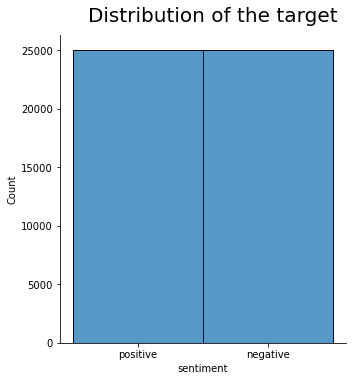

In [12]:
ax = sns.displot(df['sentiment'])
ax.fig.suptitle("Distribution of the target", fontsize=20, fontdict={"weight": "bold"}, x=0.6,  y=1.05)

The dataset consists of 50k observations and only 2 columns: the text of the review in the HTML format and the sentiment. The sentiment distribution is uniform, with equal number of positive and negative cases. This allows to safely perform the train/test split in a random mode being sure that both classes will get into the training set.  

### BASIC TEXT STATISTICS 

**Remove HTML tags.**

Firstly, we will remove all the html tags to only deal with the text from now on.

In [13]:
df['review'] = [BeautifulSoup(text).get_text() for text in df['review']]

In [14]:
df.review[3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

For simplicity, any ellipses will be regarded as a single fullstop (i.e. ".."/"..." = "."). For a more advanced analysis, the number of ellipses in a text could be collected separately and compared across the target classes. Presumably, there could be a difference in emotional expressions of review authors in the form of a extra dots.
This also sets a limitation to the analysis since any case of multiple dots will be regarded as a separate sentence whereas this might not be always the case. However, this is not a central problem for the further sentiment analysis.

The same procedure could be performed for the cases of multiple "??" or "!!" signs. However, this are extremely rare cases and thus will be disregarded. 

In [15]:
for i in df.index:
    df['review'][i] = re.sub(r'\.+', ".", df['review'][i])

**Calculate statistical metrics**

In [16]:
columns_stats = ["len", "n_sentences", "avg_sentence_len", "n_numbers", "numbers_ratio", 
                 "n_words", "avg_word_len",  "n_letters", "n_spaces", "n_capitals", 
                 "capitals_ratio"]

stats = pd.DataFrame(index=df.index.copy(), columns = columns_stats)

In [17]:
punctuation = [".", "?", "!"]

In [18]:
for i in df.index:
    stats['n_sentences'][i] = sum([df.review[i].count(c) for c in punctuation])

In [19]:
for i in df.index:
        stats['len'][i] = len(df['review'][i])
        stats['n_numbers'][i] = sum(c.isdigit() for c in df['review'][i])
        stats['numbers_ratio'][i] = stats['n_numbers'][i]/stats['len'][i]
        stats['n_words'][i] = len(df['review'][i].split())
        stats['n_letters'][i] = sum(c.isalpha() for c in df['review'][i])
        stats['avg_word_len'][i] = stats['n_letters'][i]/stats['n_words'][i]
        stats['n_spaces'][i] = sum(c.isspace() for c in df['review'][i])
        stats['n_capitals'][i] = sum(c.isupper() for c in df['review'][i])
        stats['capitals_ratio'][i] = stats['n_capitals'][i]/stats['n_letters'][i]

In [20]:
for i in df.index:
    if stats['n_sentences'][i] == 0:
        stats['avg_sentence_len'][i] = stats['len'][i]
    else: stats['avg_sentence_len'][i] = stats['len'][i]/stats['n_sentences'][i]

*Note: the above cells will take some time to run. If there are any hints for optimization, I would kill to know some!*

In [21]:
stats

,len,n_sentences,avg_sentence_len,n_numbers,numbers_ratio,n_words,avg_word_len,n_letters,n_spaces,n_capitals,capitals_ratio
0,1716,17,100.941176,1,0.000583,301,4.531561,1364,300,43,0.031525
1,962,7,137.428571,0,0.0,156,5.00641,781,155,16,0.020487
2,902,7,128.857143,1,0.001109,162,4.395062,712,161,23,0.032303
3,710,10,71.0,3,0.004225,132,4.19697,554,131,24,0.043321
4,1269,15,84.6,0,0.0,222,4.576577,1016,221,34,0.033465
...,...,...,...,...,...,...,...,...,...,...,...
49995,984,8,123.0,5,0.005081,190,3.978947,756,189,14,0.018519
49996,618,5,123.6,0,0.0,108,4.601852,497,107,19,0.038229
49997,1250,11,113.636364,0,0.0,226,4.415929,998,225,22,0.022044
49998,1234,8,154.25,2,0.001621,212,4.683962,993,211,23,0.023162


In [22]:
stats = stats.apply(pd.to_numeric)
stats.describe()

,len,n_sentences,avg_sentence_len,n_numbers,numbers_ratio,n_words,avg_word_len,n_letters,n_spaces,n_capitals,capitals_ratio
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1283.999120,13.465280,101.551922,3.232360,0.002625,227.111540,4.439995,1015.251500,226.136280,35.738900,0.035972
std,970.775488,9.785671,55.107230,5.386155,0.004030,168.277429,0.330254,771.680329,168.310296,33.967088,0.020388
min,32.000000,0.000000,2.347518,0.000000,0.000000,4.000000,0.283784,25.000000,3.000000,0.000000,0.000000
25%,688.000000,7.000000,73.400000,0.000000,0.000000,124.000000,4.223301,541.000000,123.000000,16.000000,0.024270
50%,952.000000,11.000000,93.307692,2.000000,0.001189,170.000000,4.426829,751.000000,169.000000,26.000000,0.032269
75%,1557.000000,16.000000,118.333333,4.000000,0.003926,275.000000,4.642145,1232.000000,274.000000,44.000000,0.042809
max,13584.000000,282.000000,1980.000000,185.000000,0.200869,2450.000000,12.765957,10822.000000,2449.000000,749.000000,1.000000


Perhaps we could explain some part of variation of the target with just basic statistics. Let's check the distributions for both positive and negative reviews. 

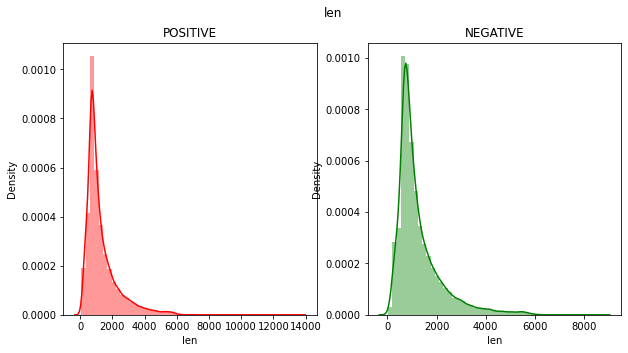

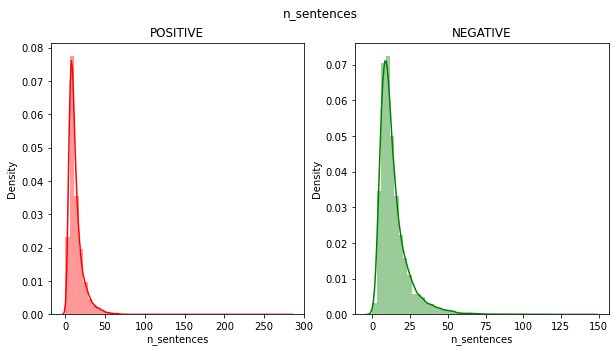

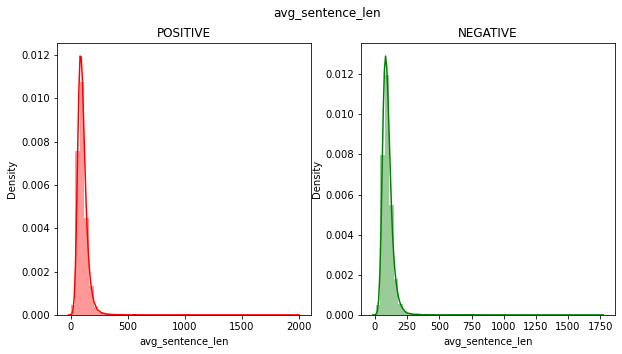

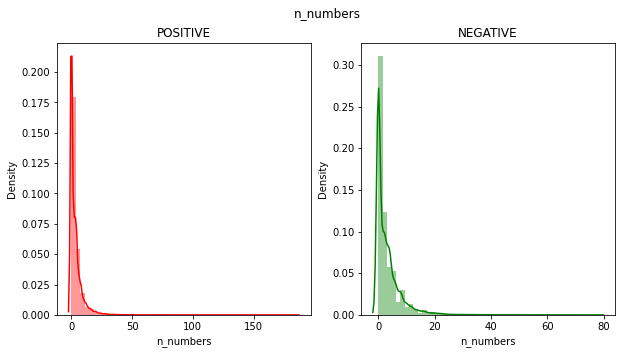

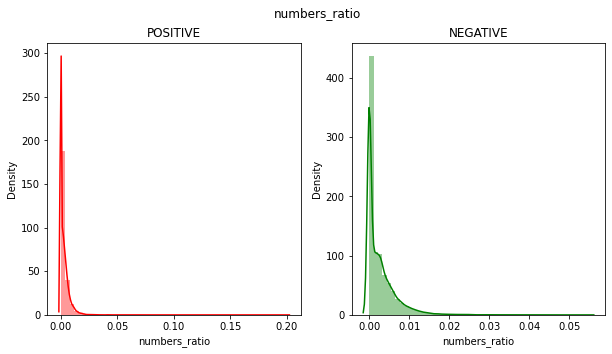

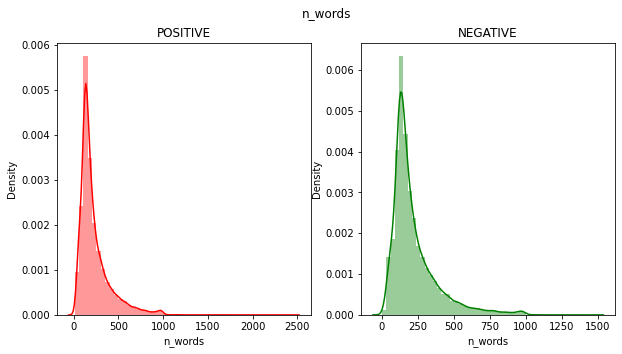

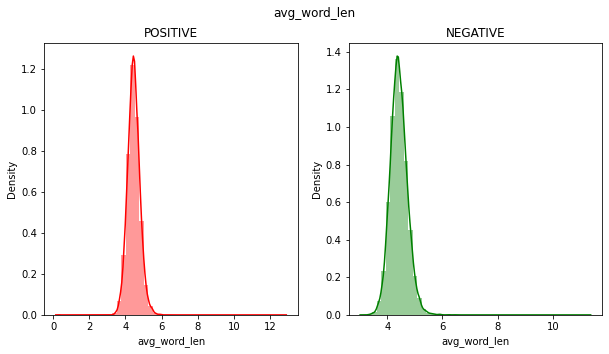

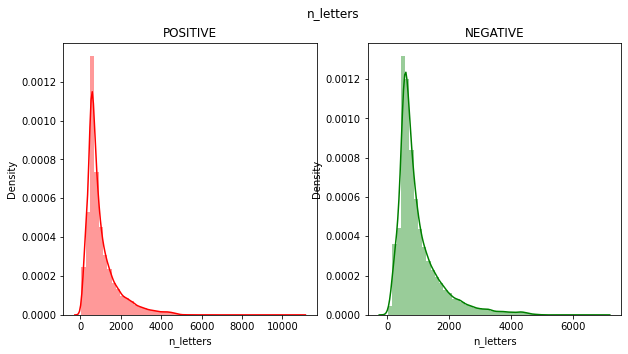

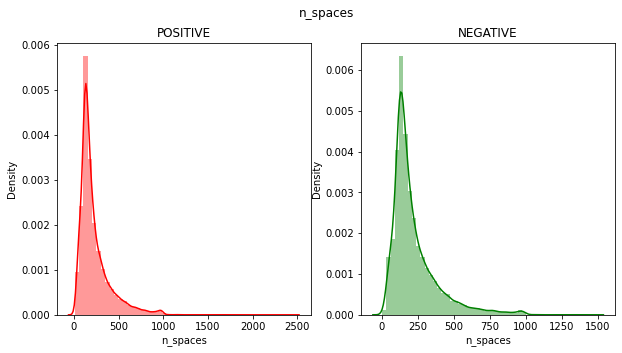

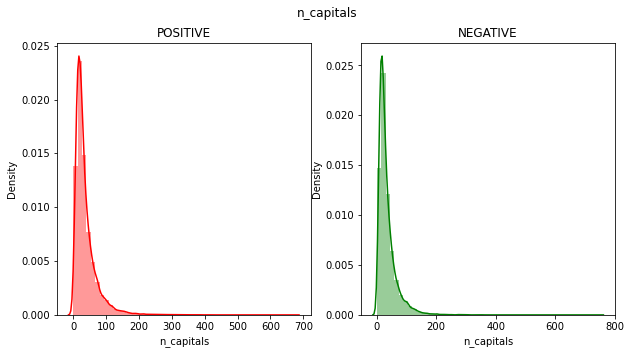

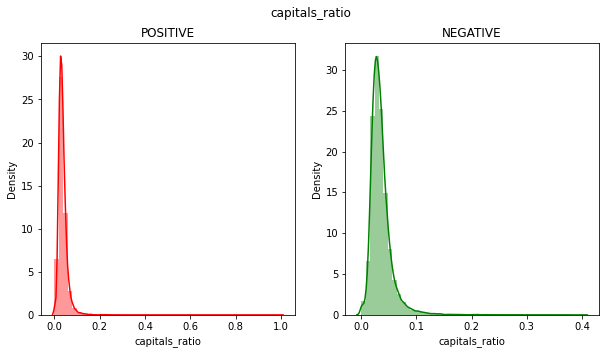

In [23]:
for stat in stats.columns:
    fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))
    sns.distplot(stats[df.sentiment == "positive"][stat], ax=ax1, color='red')
    ax1.set_title('POSITIVE')
    sns.distplot(stats[df.sentiment == "negative"][stat], ax=ax2, color='green')
    ax2.set_title('NEGATIVE')
    fig.suptitle(stat)

INTERPRETATION:
- As it can be seen from the plots, there is no significant variation observed in the distributions of the basic statistics. Most likely, adding these variables to the classification models would not result in any improvement of the accuracy metrics.

### TEXT PREPROCESSING

As just basic frequency stats for the reviews most likely cannot be used for classification, more profound analysis of the text is required. 

Firstly, the text needs to be normalized for further analysis. This includes several procedures that bring words into uniform format.

**Part 1.** Basic cleaning before tokenization

- **STEP 1.** ALL WORDS TO LOWERCASE

In [24]:
df['review'] = df.review.str.lower()

- **STEP 2.** EXPAND CONTRACTIONS

In [25]:
df['review'] =  [contractions.fix(text) for text in df['review']]

- **STEP 3.** CONVERT ACCENDED CHARACTERS

In [26]:
df['review'] = [unidecode.unidecode(text) for text in df['review']]

- **STEP 4.** REMOVE NUMBERS

In [27]:
df['review'] = [re.sub("[0-9]", "", text) for text in df['review']]

- **STEP 5.** REMOVE PUNCTUATION

In [28]:
df['review'] = [text.translate(str.maketrans('','',string.punctuation)) for text in df['review']]

- **STEP 6.** REMOVE EXTRA WHITESPACES 

In [29]:
df['review'] = [text.strip() for text in df['review']]

**Part 2.** Tokenization

In this section, all the words in the reviews are separated into tokens — the elements for further sentiment analysis. 

In [30]:
df['tokens'] = np.nan

In [31]:
for i in df.index:
    df['tokens'][i] = word_tokenize(df['review'][i])

**Part 3.** After tokenization

- **STEP 1.** REMOVE STOPWORDS

Since "no" and "not" are important words for sentiment analysis, we want to keep them. 

In [32]:
to_remove = ['no', 'not']
cashedStopWords = set(stopwords.words('english')).difference(to_remove)

In [33]:
for i in df.index:
    df['tokens'][i] = [word for word in df['tokens'][i] if not word in cashedStopWords]

- **STEP 2.** LEMMATIZATION

In [34]:
for i in df.index:
    df['tokens'][i] = [lemmatizer.lemmatize(word) for word in df['tokens'][i]]

### WORDS STATISTICS

**POSITIVE REVIEWS**

In [50]:
positive_tokens = list(itertools.chain(df['tokens'][df['sentiment']=='positive'])) 

In [57]:
positive_tokens_flat = [item for sublist in positive_tokens for item in sublist]

In [71]:
positive_tokens_count = Counter(positive_tokens_flat)
positive_tokens_count.most_common(20)

[('not', 55770),
 ('film', 47893),
 ('movie', 43133),
 ('one', 26959),
 ('like', 17540),
 ('time', 15196),
 ('good', 14419),
 ('story', 13647),
 ('character', 13633),
 ('would', 13152),
 ('great', 12694),
 ('see', 12531),
 ('get', 11097),
 ('make', 10988),
 ('well', 10979),
 ('really', 10676),
 ('also', 10553),
 ('scene', 9693),
 ('show', 9410),
 ('even', 9365)]

In [66]:
positive_tokens_dict = len(set(positive_tokens_flat))
print(positive_tokens_dict)

128255


There are 128,255 unique words in positive reviews.

**NEGATIVE REVIEWS**

In [67]:
negative_tokens = list(itertools.chain(df['tokens'][df['sentiment']=='negative'])) 

In [68]:
negative_tokens_flat = [item for sublist in negative_tokens for item in sublist]

In [72]:
negative_tokens_count = Counter(negative_tokens_flat)
negative_tokens_count.most_common(20)

[('not', 73021),
 ('movie', 55879),
 ('film', 41914),
 ('one', 25717),
 ('like', 22243),
 ('would', 17874),
 ('no', 15366),
 ('even', 14918),
 ('time', 14198),
 ('good', 14195),
 ('bad', 14092),
 ('character', 13942),
 ('get', 13337),
 ('make', 12577),
 ('really', 12223),
 ('could', 11339),
 ('I', 11255),
 ('scene', 11011),
 ('see', 10961),
 ('story', 10580)]

In [70]:
negative_tokens_dict = len(set(negative_tokens_flat))
print(negative_tokens_dict)

124984


There are 124,984 unique words in negative reviews.

Overall, we can see that there are no obvious significant differences in most freqient words across the target classes.

### TRAIN / TEST SPLIT

Before any analysis of the data, we split the dataset into train and test sets to simulate a real-life case and perform exploratory analysis and model training only with the train set. The test set is only used in the final stage for the evaluation of the models.

In [116]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['sentiment', 'tokens'], axis=1), df['sentiment'], 
                                                    test_size=0.2, shuffle=True, stratify=df['sentiment'])

**MODEL PREPARATION**

1. Target preprocessing

In [117]:
y_map = {'negative': 0,
        'positive': 1}
y_train = y_train.map(y_map)
y_test = y_test.map(y_map)

2. Features preprocessing

- Count Vectorizer

In [95]:
ngram_range = (1,1)

In [134]:
cvec = CountVectorizer(stop_words = cashedStopWords,
                               analyzer = 'word',
                               ngram_range = ngram_range)
    
X_train_cvec = cvec.fit_transform(X_train.review)
X_test_cvec = cvec.transform(X_test.review)

- TF-idf

In [139]:
tfidfvec = TfidfVectorizer(stop_words = cashedStopWords,
                                  analyzer = 'word',
                                  lowercase = True,
                                  use_idf = True,
                                  ngram_range = ngram_range)
        
X_train_tfidf = tfidfvec.fit_transform(X_train.review)
X_test_tfidf = tfidfvec.transform(X_test.review)

### SGD CLASSIFIER

In [ ]:
clf_sgd = SGDClassifier(loss = "hinge", penalty = "l1")

- With Count Vectorizer

In [137]:
clf_sgd.fit(X_train_cvec, y_train)

prediction_sgd = clf_sgd.predict(X_test_cvec)
c_rep_sgd_cvec = classification_report(y_true = y_test, y_pred = prediction_sgd)

In [138]:
print(c_rep_sgd_cvec)

              precision    recall  f1-score   support

           0       0.86      0.87      0.86      5000
           1       0.87      0.86      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



- With TF-idf

In [140]:
clf_sgd.fit(X_train_tfidf, y_train)

prediction_tfidf = clf_sgd.predict(X_test_tfidf)
c_rep_sgd_tfidf = classification_report(y_true = y_test, y_pred = prediction_tfidf)

In [141]:
print(c_rep_sgd_tfidf)

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      5000
           1       0.86      0.89      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



### NAIVE BAYES CLASSIFIER

In [ ]:
clf_nb = MultinomialNB()

- With Count Vectorizer

In [149]:
clf_nb.fit(X_train_cvec, y_train)

prediction_nb_cvec = clf_nb.predict(X_test_cvec)
c_rep_nb_cvec = classification_report(y_true = y_test, y_pred = prediction_nb_cvec)

In [150]:
print(c_rep_nb_cvec)

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      5000
           1       0.88      0.84      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



- With TF-idf

In [147]:
clf_nb.fit(X_train_tfidf, y_train)

prediction_nb_tfidf = clf_nb.predict(X_test_tfidf)
c_rep_nb_tfidf = classification_report(y_true = y_test, y_pred = prediction_nb_tfidf)

In [148]:
print(c_rep_nb_tfidf)

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      5000
           1       0.88      0.85      0.86      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



## CONCLUSIONS

From the preliminary text analysis, it couldn't be said that the reviews significantly differ by basic statistical measures and/or by the composition of the most frequent words in the text. Just looking at the calculated statistics, we most likely wouldn't be able to distinguish between a negative and a positive sample review neither by the size of the dictionary, nor length of the words, sentences or most frequent words.   

It could be the way that the counted most frequent words include some common words that don't carry much sentiment value. Perhaps, the reviews statistics would exhibit a stronger difference if analyzed by a harsher filtering of stopwords leaving only those that carry at least some extent of sentiment.

As to the models, the employed SGD and Naive Bayes ranked almost equally in terms of accuracy metrics. TF-idf vectorization leads better results, as expected, for all the models since it produced normalized word frequency inputs. 

It should be noticed that no hyperparameters tuning has been performed which could potentially result in a much better accuracy metrics for both models and would make it possible to compare them more rigorously.

**POTENTIAL IMPROVEMENTS**
- Execute SVM model. The problem was in the large time of execution. I believe there should be a way to optimize the dataset or somehow tune the model parameters to make the execution faster. 
- For all the models, compare stemming vs lemmization in terms of accuracy metrics. It could be the case that normalizing text by stemming would create more solid dependences since some of the words expressing subjective opition/emotion/attitude might have the same root and therefore mean similar things in terms of sentiment.   
- Compare various n-values for n-grams for vectorizers, check words/phrases importance.